In [1]:

import os
import shutil
import argparse
import traceback
from tqdm import tqdm
from typing import List, Dict, Tuple, Optional

from concurrent.futures import ThreadPoolExecutor, as_completed

import fiftyone as fo

from tator_tools.yolo_dataset import YOLODataset
from tator_tools.download_query import QueryDownloader
from tator_tools.train_model import ModelTrainer
from tator_tools.fiftyone_clustering import FiftyOneDatasetViewer

import tator

import cv2
import numpy as np
import pandas as pd

import torch
from ultralytics import YOLO
from ultralytics import RTDETR

from yolo_tiler import YoloTiler, TileConfig

# Custom DataDownloader (for getting select frames from media)

In [4]:
class DataDownloader:
    def __init__(self, api_token: str, project_id: int, media_ids: List[int], 
                 frame_ids_dict: Dict[int, List[int]], output_dir: str, 
                 max_workers: int = 10, max_retries: int = 10):
        """
        Initialize the DataDownloader with multiple media IDs and their corresponding frames.

        :param api_token: Tator API token for authentication
        :param project_id: Project ID in Tator
        :param media_ids: List of media IDs to process
        :param frame_ids_dict: Dictionary mapping media IDs to their frame IDs to download
        :param output_dir: Output directory for downloaded frames
        :param max_workers: Maximum number of concurrent download threads
        :param max_retries: Maximum number of retries for failed downloads
        """
        self.project_id = project_id
        self.media_ids = media_ids
        self.frames_dict = frame_ids_dict
        self.output_dir = output_dir
        self.max_workers = max_workers
        self.max_retries = max_retries
        
        # Create a single API instance for all operations
        self.api = self._authenticate(api_token)
        
        # Set up directories
        self._setup_directories()
        
        # Cache for media objects
        self.media_cache = {}
        
        # Output data
        self.output_data = None

    @staticmethod
    def _authenticate(api_token: str):
        """
        Authenticate with the Tator API.

        :param api_token: API token for authentication
        :return: Authenticated API instance
        """
        try:
            api = tator.get_api(host='https://cloud.tator.io', token=api_token)
            return api
        except Exception as e:
            raise Exception(f"ERROR: Could not authenticate with provided API Token\n{e}")

    def _setup_directories(self):
        """
        Create necessary directories for frame storage.
        """
        os.makedirs(f"{self.output_dir}/frames", exist_ok=True)

    def _get_media(self, media_id: int):
        """
        Get media object with caching to avoid redundant API calls.
        
        :param media_id: Media ID to retrieve
        :return: Media object
        """
        if media_id not in self.media_cache:
            self.media_cache[media_id] = self.api.get_media(id=int(media_id))
        return self.media_cache[media_id]

    def download_frame(self, params: tuple) -> Tuple[int, int, Optional[str]]:
        """
        Download a single frame for a given media with retry logic.

        :param params: Tuple containing (media_id, frame_id)
        :return: Tuple of (media_id, frame_id, frame_path or None if failed)
        """
        media_id, frame_id = params
        media = self._get_media(media_id)
        
        # Use absolute path for frame_path
        frame_path = os.path.abspath(f"{self.output_dir}/frames/{str(media_id)}_{str(frame_id)}.jpg")
        
        # Use absolute path for lock_path
        lock_path = f"{frame_path}.lock"
        
        # Rest of the method remains the same as before
        if os.path.exists(frame_path):
            return media_id, frame_id, frame_path
            
        if os.path.exists(lock_path):
            if os.path.getmtime(lock_path) < time.time() - 300:
                try:
                    os.remove(lock_path)
                except:
                    pass
            else:
                for _ in range(60):
                    time.sleep(1)
                    if os.path.exists(frame_path):
                        return media_id, frame_id, frame_path
                    if not os.path.exists(lock_path):
                        break
                
        try:
            with open(lock_path, 'w') as f:
                f.write(str(os.getpid()))
        except:
            time.sleep(1)
            if os.path.exists(frame_path):
                return media_id, frame_id, frame_path
        
        for attempt in range(self.max_retries):
            try:
                temp = self.api.get_frame(
                    id=media.id,
                    tile=f"{media.width}x{media.height}",
                    force_scale="1024x768",  # TODO remove hardcoding
                    frames=[int(frame_id)]
                )
                shutil.move(temp, frame_path)
                
                try:
                    os.remove(lock_path)
                except:
                    pass
                    
                return media_id, frame_id, frame_path
                
            except Exception as e:
                error_msg = f"Error downloading frame {frame_id} for media {media_id}: {e}"
                if attempt < self.max_retries - 1:
                    print(f"{error_msg}, retrying...")
                    time.sleep(2 ** attempt)
                else:
                    print(f"{error_msg}, giving up.")
        
        try:
            os.remove(lock_path)
        except:
            pass
            
        return media_id, frame_id, None

    def download_data(self) -> Dict[int, List[str]]:
        """
        Download frames for all media IDs using a single thread pool.

        :return: Dictionary mapping media IDs to lists of frame paths
        """
        # Prepare all download tasks
        all_tasks = []
        for media_id in self.media_ids:
            frames = self.frames_dict[media_id]
            for frame_id in frames:
                all_tasks.append((media_id, frame_id))
        
        results_dict = {media_id: [] for media_id in self.media_ids}
        
        # Use a single thread pool for all downloads
        with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
            futures = {
                executor.submit(self.download_frame, task): task 
                for task in all_tasks
            }
            
            with tqdm(total=len(all_tasks), desc="Downloading frames") as pbar:
                for future in as_completed(futures):
                    media_id, frame_id, frame_path = future.result()
                    if frame_path:  # If download was successful
                        results_dict[media_id].append(frame_path)
                    pbar.update(1)
        
        self.output_data = results_dict


In [5]:
api_token = os.getenv("TATOR_TOKEN")
project_id = 155

output_dir="../Data/NCICS/Madeline_Data/"

# Read in CSV file

In [21]:
# Read and preprocess the data
df = pd.read_csv("../Data/NCICS/MadelineIs_All_Annotations_20241113.csv")

# Only drop rows where TatorMediaID OR TatorFrame have NA values
df = df.dropna(subset=['TatorMediaID', 'TatorFrame'])

# Convert the columns to integers after removing NA values
df['TatorMediaID'] = df['TatorMediaID'].astype(int)
df['TatorFrame'] = df['TatorFrame'].astype(int)

# Create dictionary mapping media IDs to their frame lists
media_ids = df['TatorMediaID'].unique().tolist()
frame_ids_dict = {media_id: df[df['TatorMediaID'] == media_id]['TatorFrame'].tolist() for media_id in media_ids}

# Download frames from CSV

In [ ]:
# Initialize downloader with multiple media IDs
downloader = DataDownloader(
    api_token=api_token,
    project_id=project_id,
    media_ids=media_ids,
    frame_ids_dict=frame_ids_dict,
    output_dir=output_dir,
    max_workers=10,
    max_retries=10,
)

# Download all frames for all media IDs
downloader.download_data()

In [25]:
frame_paths_dict = downloader.output_data

In [26]:
# Create a new dataframe with the paths
output_df = []
for media_id, group in df.groupby('TatorMediaID'):
    # Get the frame paths for this media ID
    media_frame_paths = frame_paths_dict[media_id]
    
    # Create a mapping of frame number to path
    frame_to_path = {
        int(path.split('_')[-1].replace('.jpg', '')): path 
        for path in media_frame_paths
    }
    
    # Add paths to the group
    group = group.copy()
    group['Image_Path'] = group['TatorFrame'].map(frame_to_path)
    output_df.append(group)

# Combine all groups back into a single dataframe
final_df = pd.concat(output_df, ignore_index=True)

In [ ]:
final_df[['TatorMediaID', 'TatorFrame', 'Image_Path', 'Sclass', 'Ssubclass', 'Sgroup']].head(3)

In [28]:
# Create and output updated dataframe with the paths
final_df.to_csv("../Data/NCICS/Madeline_Data/MadelineIs_Modified.csv", index=False)

# Download Unlabeled AUV Data

In [4]:
# Search string comes from Tator's Data Metadata Export utility
search_string = "eyJtZXRob2QiOiJBTkQiLCJvcGVyYXRpb25zIjpbeyJhdHRyaWJ1dGUiOiJNaXNzaW9uTmFtZSIsIm9wZXJhdGlvbiI6Imljb250YWlucyIsImludmVyc2UiOmZhbHNlLCJ2YWx1ZSI6Ik1hZGVsaW5lIn0seyJtZXRob2QiOiJPUiIsIm9wZXJhdGlvbnMiOlt7ImF0dHJpYnV0ZSI6IiR0eXBlIiwib3BlcmF0aW9uIjoiZXEiLCJpbnZlcnNlIjpmYWxzZSwidmFsdWUiOjMzMX1dfV19"

# Demo for downloading labeled data
frac = 0.01

dataset_name = "Unlabeled_AUV_Data"
output_dir = "../Data/NCICS/"

In [ ]:
# Create a downloader for the labeled data
downloader = DatasetDownloader(api_token,
                               project_id=project_id,
                               search_string=search_string,
                               frac=frac,
                               output_dir=output_dir,
                               dataset_name=dataset_name,
                               label_field="",
                               download_width=1024)

In [ ]:
# Download the labeled data
downloader.download_data()

In [11]:
df = downloader.as_dataframe()  # .as_dict()

In [12]:
df.to_csv("../Data/NCICS/Unlabeled_AUV_Data/Unlabeled_AUV_Data.csv", index=False)

# Make a YOLO Image Classification Dataset

In [2]:
# Get the labeled data, subset
labeled_df = pd.read_csv("../Data/NCICS/Madeline_Data/MadelineIs_Modified.csv")
labeled_df = labeled_df[['Path', 'Sclass', 'Ssubclass', 'Sgroup']]

df = labeled_df.copy()
df['image_path'] = df['Path']
df['image_name'] = df['Path'].apply(lambda x: os.path.basename(x))
df['label'] = df['Ssubclass']

# Fill with nulls
df['x'] = np.nan
df['y'] = np.nan
df['width'] = np.nan
df['height'] = np.nan
df['polygon'] = np.nan

# Show class distribution
df['label'].value_counts()

label
Gravel Substrate    219
Muddy Substrate     209
Mixed Gravels       177
Sandy Substrate     134
Bedrock              81
Trace Gravels        61
Unclassifiable       28
Name: count, dtype: int64

In [3]:
# Set parameters
output_dir = "../Data/NCICS/Madeline_Data/"
dataset_name = "YOLO_Classification_Dataset"

train_ratio = 0.8
test_ratio = 0.1

task = 'classify' # 'classify', 'detect', 'segment'

In [4]:
# Create and process dataset
dataset = YOLODataset(
    data=df,
    output_dir=output_dir,
    dataset_name=dataset_name,
    train_ratio=train_ratio,
    test_ratio=test_ratio,
    task=task,
    format_class_names=False, 
)

In [ ]:
# Process the dataset
dataset.process_dataset(move_images=False)  # Makes a copy of the images instead of moving them

In [ ]:
dataset.output_dir

# Tile YOLO Datset (Optional)

In [11]:
src = dataset.dataset_dir                                           # Source YOLO dataset directory
dst = f"{dataset.output_dir}\\YOLO_Classification_Dataset_Tiled"    # Output directory for tiled dataset

config = TileConfig(
    # Size of each tile (width, height). Can be:
    # - Single integer for square tiles: slice_wh=640
    # - Tuple for rectangular tiles: slice_wh=(640, 480)
    slice_wh=(768, 512),

    # Overlap between adjacent tiles. Can be:
    # - Single float (0-1) for uniform overlap percentage: overlap_wh=0.1
    # - Tuple of floats for different overlap in each dimension: overlap_wh=(0.1, 0.1)
    # - Single integer for pixel overlap: overlap_wh=64
    # - Tuple of integers for different pixel overlaps: overlap_wh=(64, 48)
    overlap_wh=(0.2, 0.2),

    # Input image file extension to process
    input_ext=".jpg",

    # Output image file extension to save (default: same as input_ext)
    output_ext=None,

    # Type of YOLO annotations to process:
    # - "image_classification": Standard YOLO format (class)
    # - "object_detection": Standard YOLO format (class, x, y, width, height)
    # - "instance_segmentation": YOLO segmentation format (class, x1, y1, x2, y2, ...)
    annotation_type="image_classification",

    # Include negative samples (tiles without any instances)
    include_negative_samples=True
)

tiler = YoloTiler(
    source=src,
    target=dst,
    config=config,
    num_viz_samples=15,                     # Number of samples to visualize
    show_processing_status=True,            # Show the progress of the tiling process
)

In [ ]:
tiler.run()

# Train a YOLO model

In [ ]:
training_data = f"../Data/NCICS/Madeline_Data/YOLO_Classification_Dataset_Tiled/"

# Initialize the trainer with the required parameters
trainer = ModelTrainer(
    training_data=training_data,
    weights="yolov8m-cls.pt",
    output_dir=f"{training_data}/results",
    name="yolov8m",
    task='classify',
    epochs=100,
    patience=10,
    half=True,
    imgsz=640,
    single_cls=False,
    plots=True,
    batch=0.5,
)

In [ ]:
# Train the model
trainer.train_model()

In [ ]:
# Evaluate on the model (if test data is available)
trainer.evaluate_model()

# Clustering

In [24]:
def calculate_embeddings(df: pd.DataFrame, model_weights: str, imgsz: int, image_column: str = "Path") -> np.ndarray:
    """
    Calculate embeddings for a given dataframe using a YOLO model.
    """
    # Load the model
    model = YOLO(model_weights)
    # Get the image size
    imgsz = model.__dict__['overrides']['imgsz']

    # Get the device
    device ='cuda' if torch.cuda.is_available() else 'cpu'
    print(f"NOTE: Using device {device}")

    # Run a blank image through the model to load the weights
    _ = model(np.zeros((imgsz, imgsz, 3), dtype=np.uint8), device=device) 

    embeddings_list = []

    # Use the length of df as the total for tqdm
    total_items = len(df)
    for path in tqdm(df['Path'].tolist(), total=total_items, desc="Calculating embeddings"):
        embeddings = model.embed(path, imgsz=imgsz, stream=False, device=device, verbose=False)
        embeddings_list.append(embeddings[0].cpu().numpy())
    
    # Convert the embeddings list to a numpy array
    embeddings = np.array(embeddings_list)
     
    # Clear the cache
    torch.cuda.empty_cache()  
    
    return embeddings



In [ ]:
# Get the model weights
model_weights = "E:\\tator-tools\\Data\\NCICS\\Madeline_Data\\YOLO_Classification_Dataset_Tiled\\results\\yolov8m\\weights\\best.pt"

In [16]:
# Get the labeled data
labeled_df = pd.read_csv("../Data/NCICS/Madeline_Data/MadelineIs_Modified.csv")
labeled_df = labeled_df[['Path', 'Sclass', 'Ssubclass', 'Sgroup']]

# Drop any rows with NA values
labeled_df = labeled_df.dropna(subset=['Path', 'Sclass', 'Ssubclass', 'Sgroup'])

In [25]:
# Calculate the embeddings
embeddings = calculate_embeddings(labeled_df, model_weights, 640, image_column="Path")

NOTE: Using device cuda

0: 640x640 Muddy Substrate 0.31, Sandy Substrate 0.19, Unclassifiable 0.14, Mixed Gravels 0.10, Trace Gravels 0.10, 70.0ms
Speed: 13.0ms preprocess, 70.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Calculating embeddings: 100%|██████████| 828/828 [00:46<00:00, 17.81it/s]


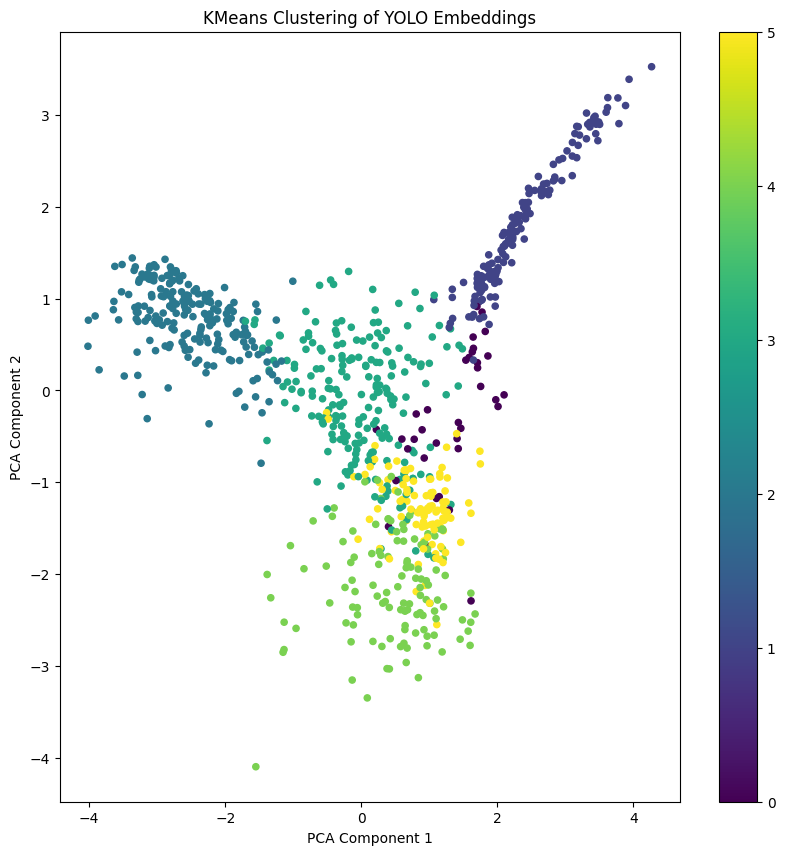

In [26]:
# Run KMeans clustering using embeddings and visualize the results
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

label_group = 'Ssubclass'
assert label_group in labeled_df.columns, f"ERROR: {label_group} not found in the dataframe"

# Number of cluters based on label group
n_clusters = labeled_df[label_group].nunique()

# Initialize the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

# Fit the model
kmeans.fit(embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Add the cluster labels to the dataframe
labeled_df['cluster'] = cluster_labels

# Visualize the clusters using matplotlib
import matplotlib.pyplot as plt

# Reduce the dimensionality of the embeddings
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', s=20)
plt.title("KMeans Clustering of YOLO Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()


In [32]:
# Get the unlabeled data, subset, conform
unlabeled_df = pd.read_csv("../Data/NCICS/Unlabeled_AUV_Data/Unlabeled_AUV_Data.csv")
unlabeled_df = unlabeled_df[['image_path']]
unlabeled_df['Path'] = unlabeled_df['image_path']

# No labels, set as Unlabeled
unlabeled_df['Sclass'] = "Unlabeled"
unlabeled_df['Ssubclass'] = "Unlabeled"
unlabeled_df['Sgroup'] = "Unlabeled"

# Drop the image_path column
unlabeled_df.drop(columns=['image_path'], inplace=True)

unlabeled_df.head(3)

,Path,Sclass,Ssubclass,Sgroup
0,e:\tator-tools\Data\NCICS\Unlabeled_AUV_Data\i...,Unlabeled,Unlabeled,Unlabeled
1,e:\tator-tools\Data\NCICS\Unlabeled_AUV_Data\i...,Unlabeled,Unlabeled,Unlabeled
2,e:\tator-tools\Data\NCICS\Unlabeled_AUV_Data\i...,Unlabeled,Unlabeled,Unlabeled


In [36]:
# Import additional libraries
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

# Fit the KMeans model on the unlabeled data
unlabeled_embeddings = calculate_embeddings(unlabeled_df, model_weights, 640, image_column="Path")
unlabeled_cluster_labels = kmeans.predict(unlabeled_embeddings)

# Add the cluster labels to the dataframes
unlabeled_df['cluster'] = unlabeled_cluster_labels

# Combine labeled and unlabeled data for visualization
combined_df = pd.concat([labeled_df, unlabeled_df], ignore_index=True)
combined_df['dataset_type'] = ['Labeled'] * len(labeled_df) + ['Unlabeled'] * len(unlabeled_df)

# Reduce the dimensionality of all embeddings
pca = PCA(n_components=2)
all_embeddings = np.concatenate([embeddings, unlabeled_embeddings])
all_embeddings_2d = pca.fit_transform(all_embeddings)

# Analyze cluster distribution among labeled data to see what each cluster represents
cluster_class_distribution = pd.crosstab(labeled_df['cluster'], labeled_df['Ssubclass'])
print("\nCluster to Class mapping:")
print(cluster_class_distribution)

# Map each cluster to the majority class based on labeled data
cluster_to_class_mapping = {}
for cluster in cluster_class_distribution.index:
    majority_class = cluster_class_distribution.loc[cluster].idxmax()
    cluster_to_class_mapping[cluster] = majority_class
    print(f"Cluster {cluster} maps to class '{majority_class}'")

# Assign predicted classes based on cluster assignments
labeled_df['predicted_class'] = labeled_df['cluster'].map(cluster_to_class_mapping)
unlabeled_df['predicted_class'] = unlabeled_df['cluster'].map(cluster_to_class_mapping)
combined_df['predicted_class'] = combined_df['cluster'].map(cluster_to_class_mapping)

# Calculate accuracy on labeled data
accuracy = accuracy_score(labeled_df['Ssubclass'], labeled_df['predicted_class'])
print(f"\nClustering accuracy on labeled data: {accuracy:.4f}")

NOTE: Using device cuda

0: 640x640 Muddy Substrate 0.31, Sandy Substrate 0.19, Unclassifiable 0.14, Mixed Gravels 0.10, Trace Gravels 0.10, 71.0ms
Speed: 13.0ms preprocess, 71.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)


Calculating embeddings: 100%|██████████| 270/270 [00:15<00:00, 16.93it/s]


Cluster to Class mapping:
Ssubclass  Gravel Substrate  Mixed Gravels  Muddy Substrate  Sandy Substrate  \
cluster                                                                        
0                         0              0               12               12   
1                         0              0               83                6   
2                       207              3                0                0   
3                         9            154                0               34   
4                         0              9               87               25   
5                         3             11               27               57   

Ssubclass  Trace Gravels  Unclassifiable  
cluster                                   
0                      9               2  
1                     28              26  
2                      0               0  
3                     18               0  
4                      1               0  
5                      5       

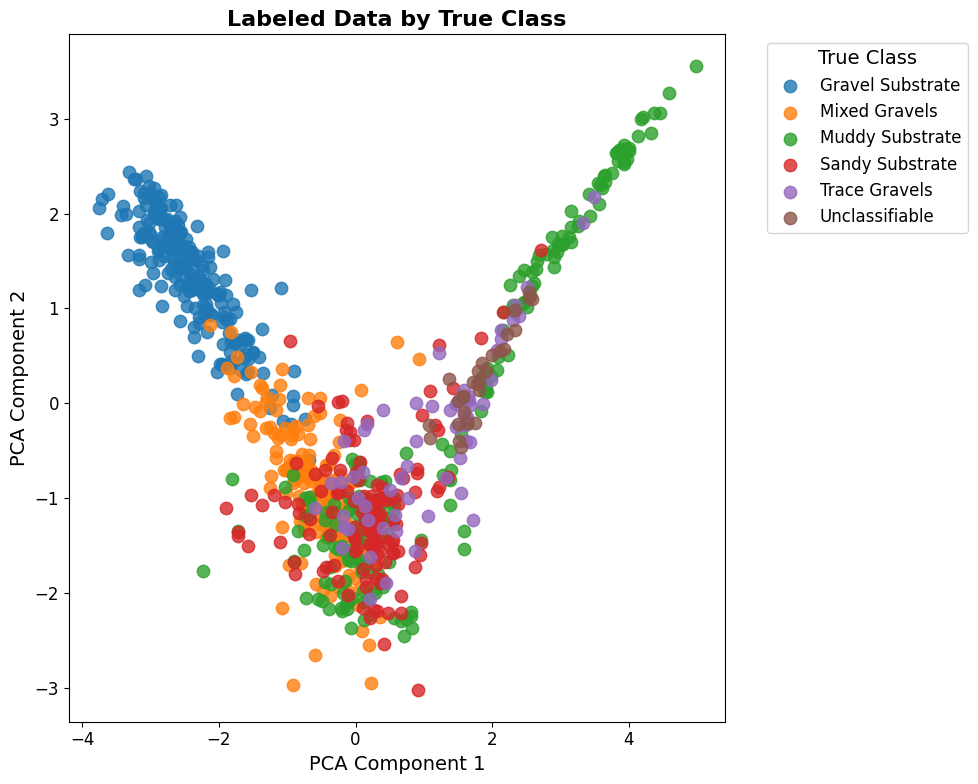

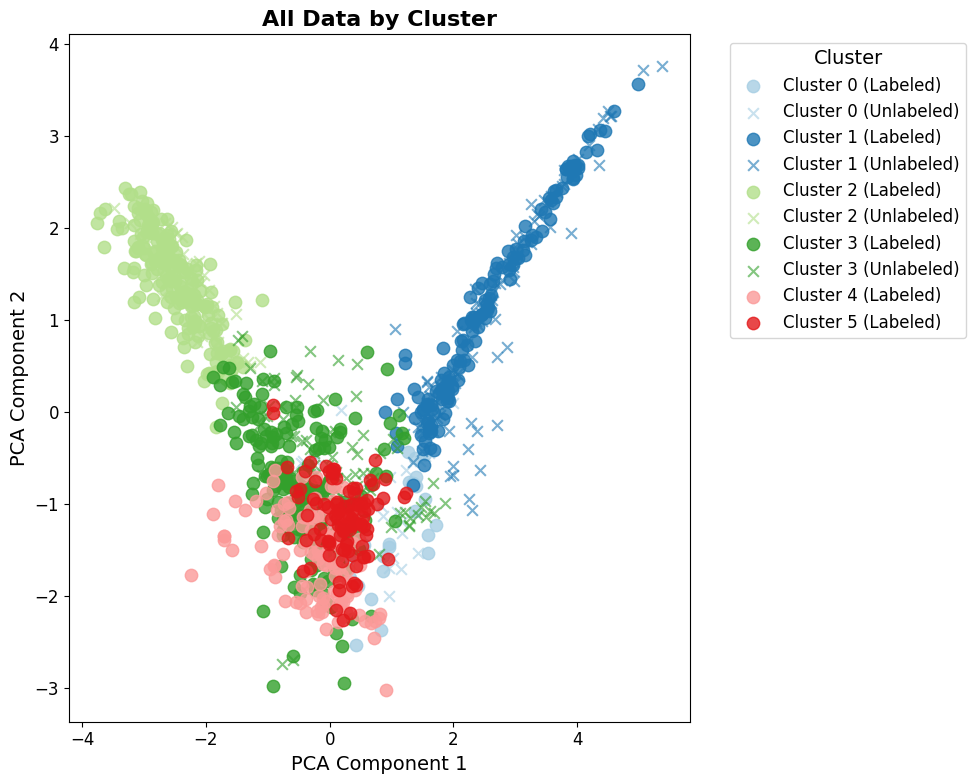

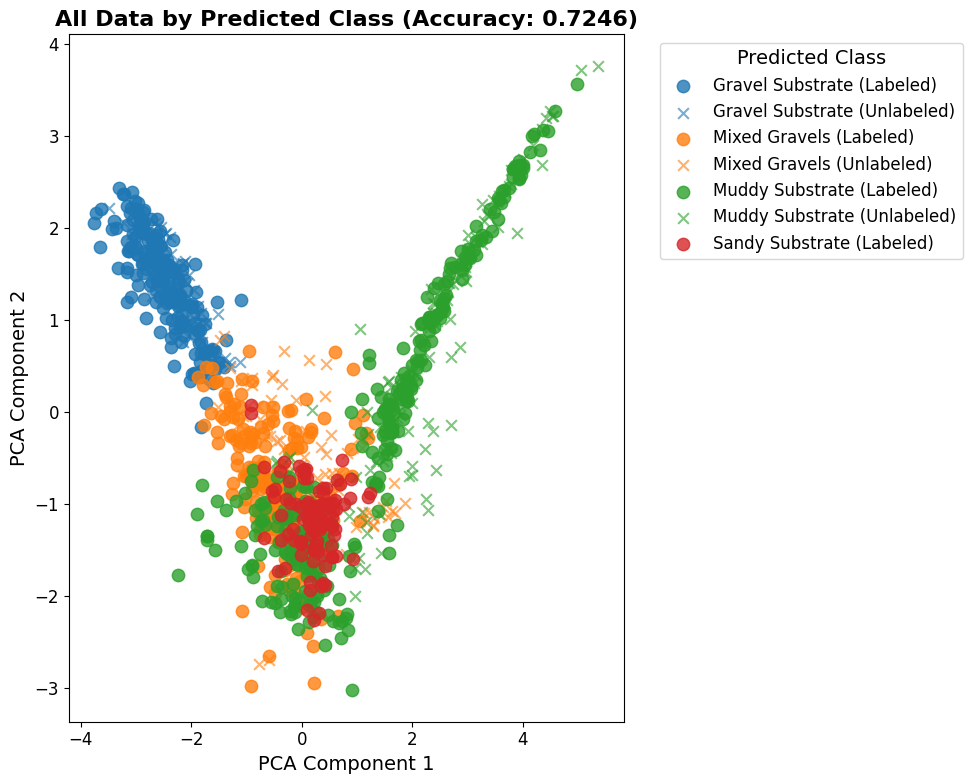

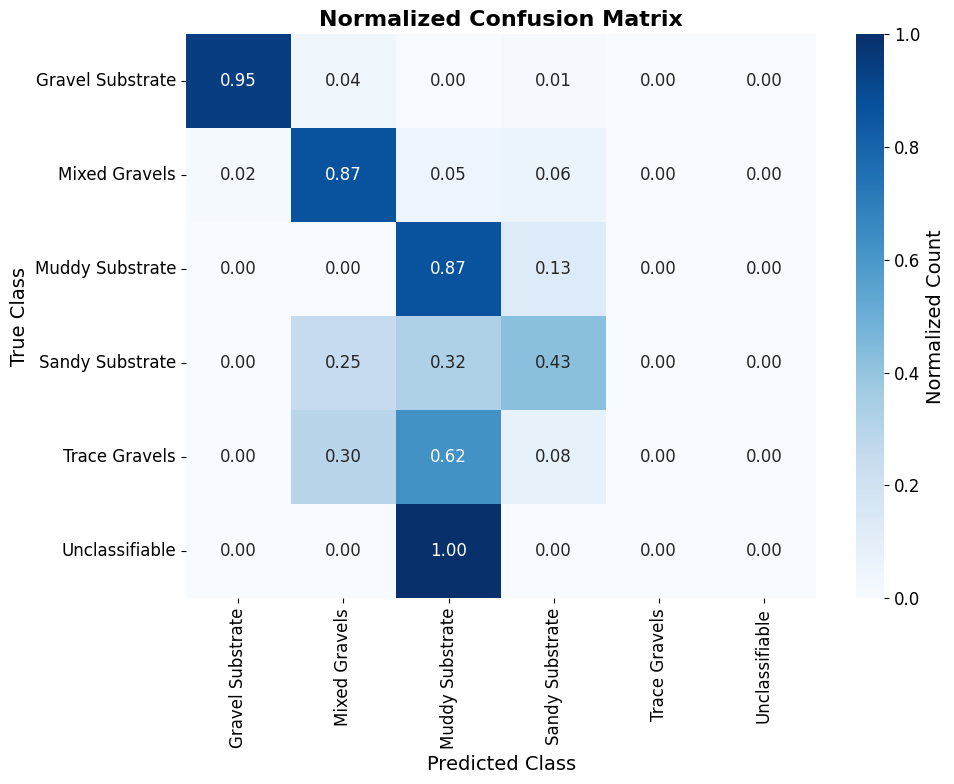

<Figure size 1200x800 with 0 Axes>

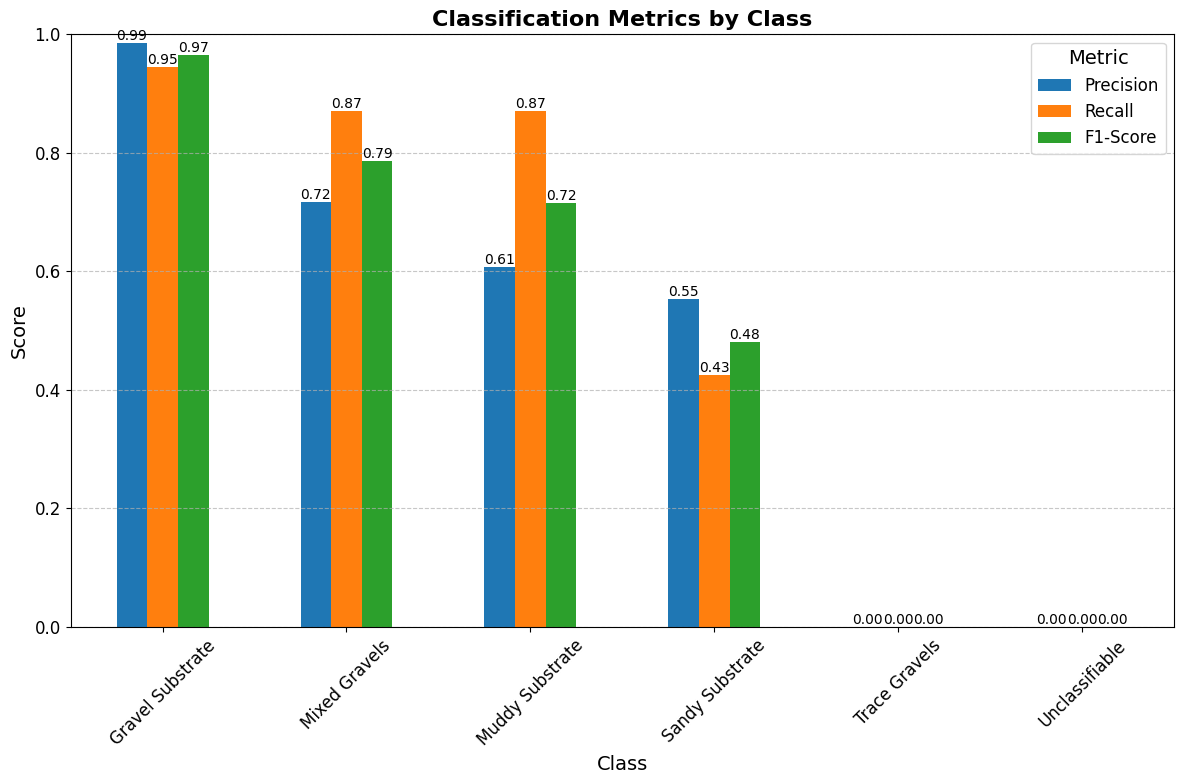


Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



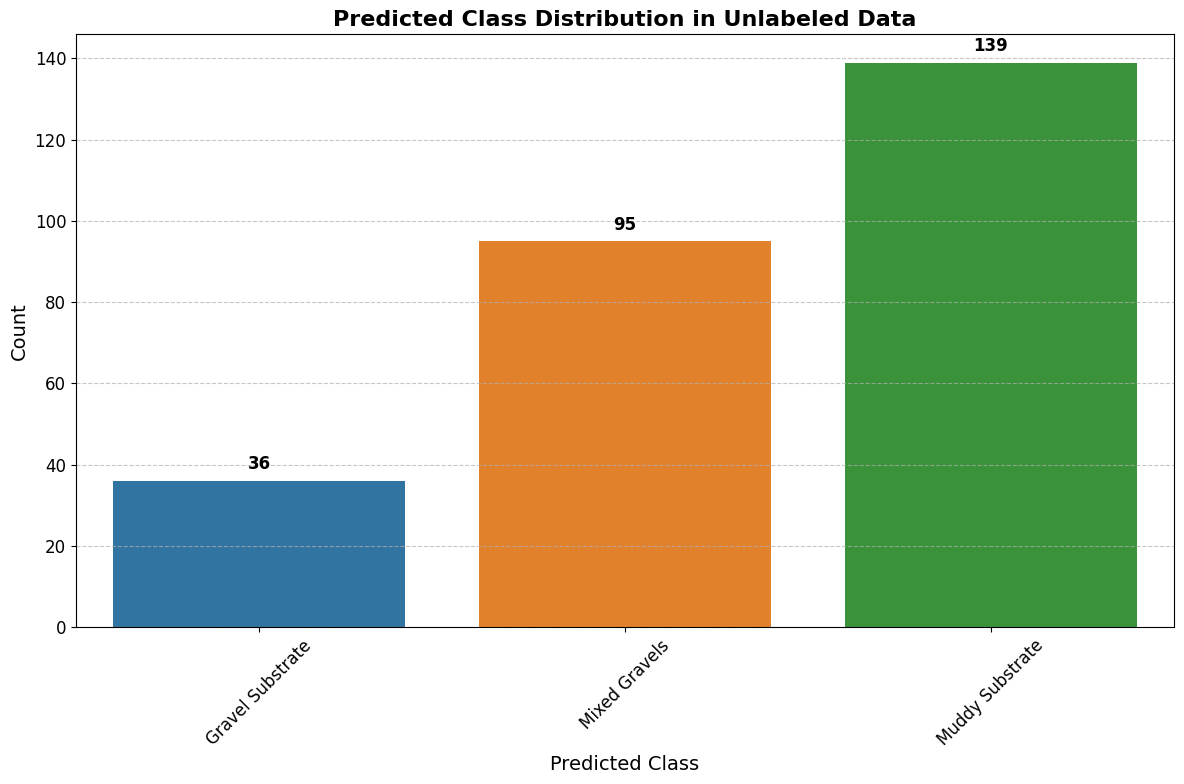

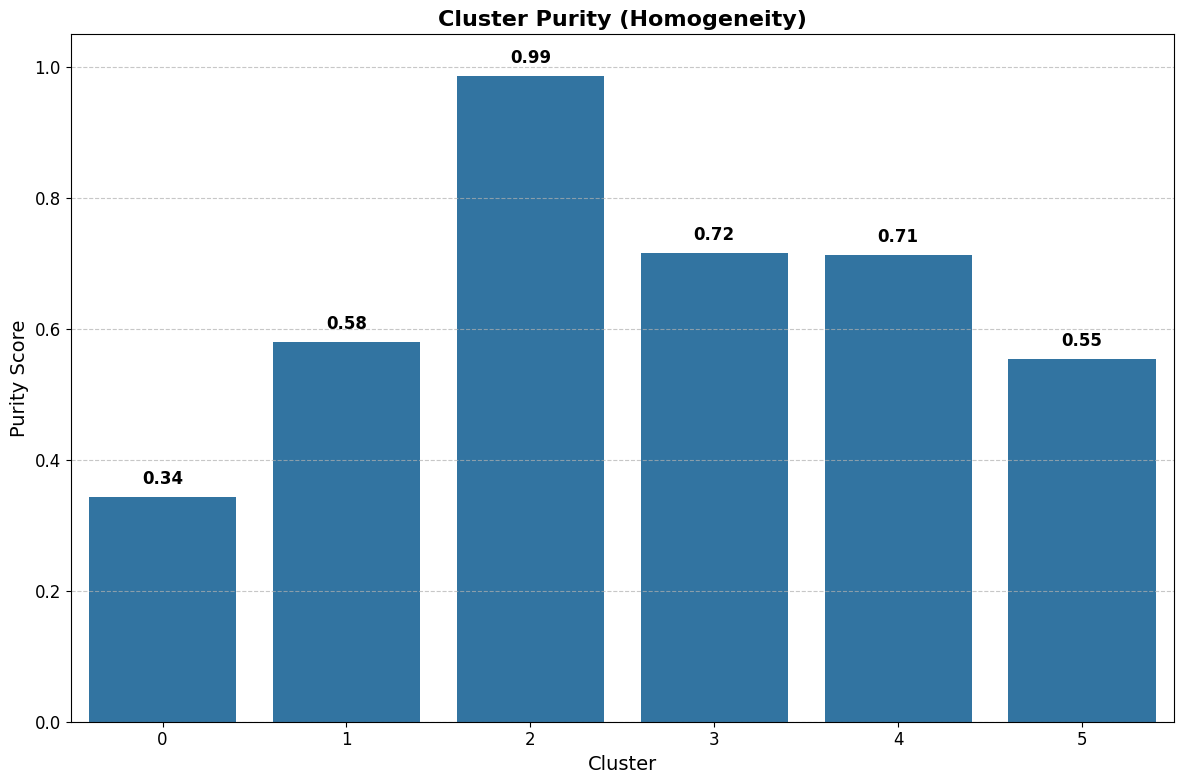

<Figure size 1400x800 with 0 Axes>

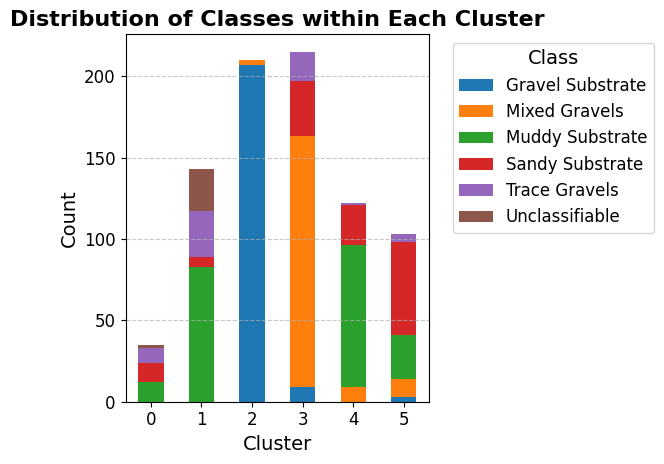

In [52]:
# Extract embeddings for labeled and unlabeled data
labeled_embeddings_2d = all_embeddings_2d[:len(labeled_df)]
unlabeled_embeddings_2d = all_embeddings_2d[len(labeled_df):]

# Create color mappings
true_class_colors = {cls: plt.cm.tab10(i) for i, cls in enumerate(sorted(labeled_df['Ssubclass'].unique()))}
cluster_colors = {cls: plt.cm.Paired(i) for i, cls in enumerate(sorted(combined_df['cluster'].unique()))}

# Set consistent font sizes for better readability
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'legend.title_fontsize': 14
})

# 1. Plot by true class (labeled data only)
plt.figure(figsize=(10, 8))
for cls, group in labeled_df.groupby('Ssubclass'):
    mask = labeled_df['Ssubclass'] == cls
    plt.scatter(labeled_embeddings_2d[mask, 0], 
                labeled_embeddings_2d[mask, 1], 
                color=true_class_colors[cls], label=cls, s=80, alpha=0.8)
plt.legend(title="True Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Labeled Data by True Class", fontweight='bold')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

# 2. Plot by cluster (all data)
plt.figure(figsize=(10, 8))
for cluster, group in combined_df.groupby('cluster'):
    labeled_mask = (combined_df['dataset_type'] == 'Labeled') & (combined_df['cluster'] == cluster)
    unlabeled_mask = (combined_df['dataset_type'] == 'Unlabeled') & (combined_df['cluster'] == cluster)
    
    # Plot labeled data
    if np.any(labeled_mask):
        labeled_indices = np.where(labeled_mask)[0]
        plt.scatter(all_embeddings_2d[labeled_indices, 0], 
                    all_embeddings_2d[labeled_indices, 1], 
                    color=cluster_colors[cluster], marker='o', 
                    label=f"Cluster {cluster} (Labeled)", s=80, alpha=0.8)
    
    # Plot unlabeled data
    if np.any(unlabeled_mask):
        unlabeled_indices = np.where(unlabeled_mask)[0]
        plt.scatter(all_embeddings_2d[unlabeled_indices, 0], 
                    all_embeddings_2d[unlabeled_indices, 1], 
                    color=cluster_colors[cluster], marker='x', 
                    label=f"Cluster {cluster} (Unlabeled)", s=60, alpha=0.6)

plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("All Data by Cluster", fontweight='bold')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

# 3. Plot by predicted class (all data)
plt.figure(figsize=(10, 8))
for cls, group in combined_df.groupby('predicted_class'):
    labeled_mask = (combined_df['dataset_type'] == 'Labeled') & (combined_df['predicted_class'] == cls)
    unlabeled_mask = (combined_df['dataset_type'] == 'Unlabeled') & (combined_df['predicted_class'] == cls)
    
    # Plot labeled data
    if np.any(labeled_mask):
        labeled_indices = np.where(labeled_mask)[0]
        plt.scatter(all_embeddings_2d[labeled_indices, 0], 
                    all_embeddings_2d[labeled_indices, 1], 
                    color=true_class_colors.get(cls, 'gray'), marker='o', 
                    label=f"{cls} (Labeled)", s=80, alpha=0.8)
    
    # Plot unlabeled data
    if np.any(unlabeled_mask):
        unlabeled_indices = np.where(unlabeled_mask)[0]
        plt.scatter(all_embeddings_2d[unlabeled_indices, 0], 
                    all_embeddings_2d[unlabeled_indices, 1], 
                    color=true_class_colors.get(cls, 'gray'), marker='x', 
                    label=f"{cls} (Unlabeled)", s=60, alpha=0.6)

plt.legend(title="Predicted Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"All Data by Predicted Class (Accuracy: {accuracy:.4f})", fontweight='bold')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()

# 4. Confusion matrix
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(labeled_df['Ssubclass'], labeled_df['predicted_class'])
# Normalize confusion matrix for better visualization
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=sorted(labeled_df['Ssubclass'].unique()),
            yticklabels=sorted(labeled_df['Ssubclass'].unique()),
            cbar_kws={'label': 'Normalized Count'})
plt.title('Normalized Confusion Matrix', fontweight='bold')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# 5. Per-class metrics: Precision, Recall, F1-score
plt.figure(figsize=(12, 8))
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Calculate precision, recall, and F1 for each class
precision, recall, f1, _ = precision_recall_fscore_support(
    labeled_df['Ssubclass'], labeled_df['predicted_class'], average=None)

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=sorted(labeled_df['Ssubclass'].unique()))

# Plot as a grouped bar chart
ax = metrics_df.plot(kind='bar', figsize=(12, 8))
plt.title("Classification Metrics by Class", fontweight='bold')
plt.xlabel("Class")
plt.ylabel("Score")
plt.ylim(0, 1.0)
plt.legend(title="Metric")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', fontsize=10)

plt.tight_layout()
plt.show()

# 6. Distribution of predicted classes in unlabeled data
plt.figure(figsize=(12, 8))
class_counts = unlabeled_df['predicted_class'].value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values, 
            palette={cls: true_class_colors.get(cls, 'gray') for cls in class_counts.index})
plt.title("Predicted Class Distribution in Unlabeled Data", fontweight='bold')
plt.xlabel("Predicted Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add count values on top of bars
for i, v in enumerate(class_counts.values):
    plt.text(i, v + (max(class_counts.values) * 0.02), str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 7. Cluster purity plot
plt.figure(figsize=(12, 8))
cluster_purity = {}
for cluster in cluster_class_distribution.index:
    total = cluster_class_distribution.loc[cluster].sum()
    majority = cluster_class_distribution.loc[cluster].max()
    cluster_purity[cluster] = majority / total

ax = sns.barplot(x=list(cluster_purity.keys()), y=list(cluster_purity.values()))
plt.title("Cluster Purity (Homogeneity)", fontweight='bold')
plt.xlabel("Cluster")
plt.ylabel("Purity Score")
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on top of bars
for i, v in enumerate(cluster_purity.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# 8. Distribution of classes within each cluster (stacked bar chart)
plt.figure(figsize=(14, 8))
cluster_class_distribution.plot(kind='bar', stacked=True)
plt.title("Distribution of Classes within Each Cluster", fontweight='bold')
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

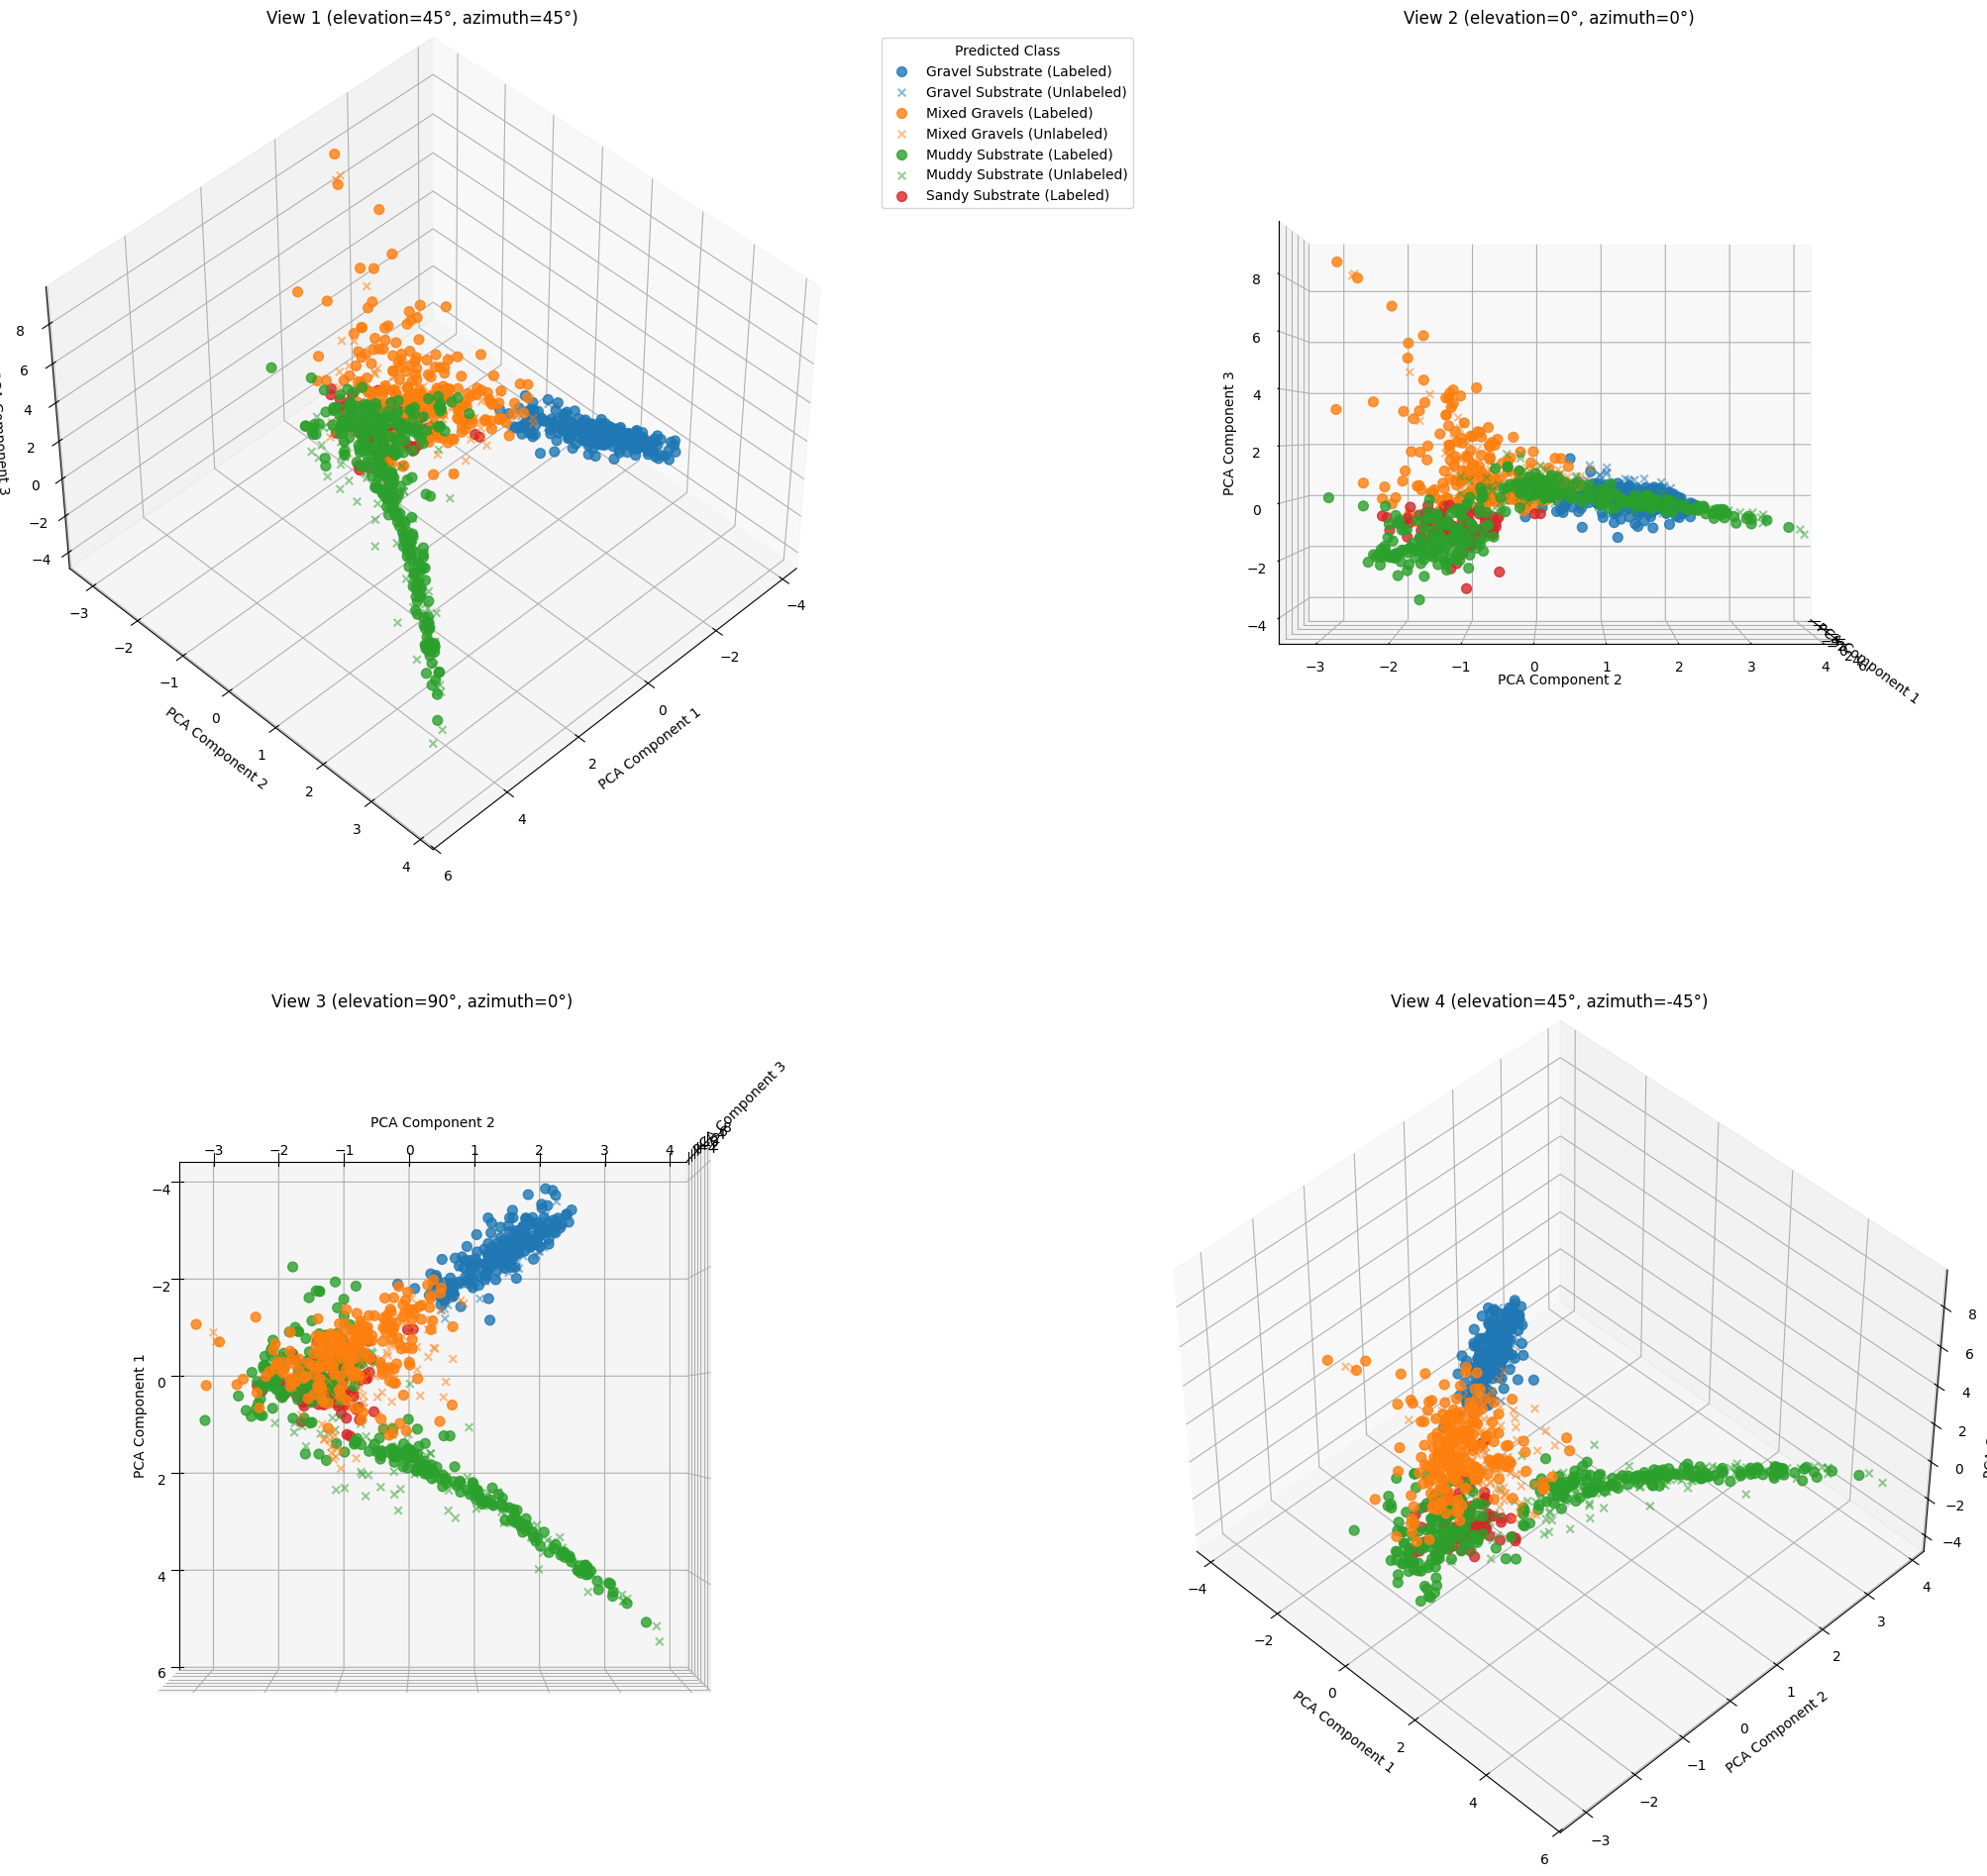

In [48]:
# 4. 3D visualization from multiple angles
from mpl_toolkits.mplot3d import Axes3D

# Optional: Use PCA with 3 components for 3D visualization
pca_3d = PCA(n_components=3)
all_embeddings_3d = pca_3d.fit_transform(all_embeddings)

# Create a figure with 4 subplots
fig = plt.figure(figsize=(20, 20))

# Define viewing angles for each subplot
views = [
    (45, 45),   # Top-right view
    (0, 0),     # Front view
    (90, 0),    # Side view
    (45, -45)   # Bottom-right view
]

for idx, (elev, azim) in enumerate(views, 1):
    ax = fig.add_subplot(2, 2, idx, projection='3d')
    
    # Plot by predicted class with different markers for labeled and unlabeled
    for cls, group in combined_df.groupby('predicted_class'):
        labeled_mask = (combined_df['dataset_type'] == 'Labeled') & (combined_df['predicted_class'] == cls)
        unlabeled_mask = (combined_df['dataset_type'] == 'Unlabeled') & (combined_df['predicted_class'] == cls)
        
        # Plot labeled data
        if np.any(labeled_mask):
            labeled_indices = np.where(labeled_mask)[0]
            ax.scatter(all_embeddings_3d[labeled_indices, 0], 
                      all_embeddings_3d[labeled_indices, 1], 
                      all_embeddings_3d[labeled_indices, 2],
                      color=true_class_colors.get(cls, 'gray'), marker='o', 
                      label=f"{cls} (Labeled)", s=50, alpha=0.8)
        
        # Plot unlabeled data
        if np.any(unlabeled_mask):
            unlabeled_indices = np.where(unlabeled_mask)[0]
            ax.scatter(all_embeddings_3d[unlabeled_indices, 0], 
                      all_embeddings_3d[unlabeled_indices, 1], 
                      all_embeddings_3d[unlabeled_indices, 2],
                      color=true_class_colors.get(cls, 'gray'), marker='x', 
                      label=f"{cls} (Unlabeled)", s=30, alpha=0.5)
    
    # Set the viewing angle
    ax.view_init(elev=elev, azim=azim)
    
    # Only add legend to the first subplot
    if idx == 1:
        ax.legend(title="Predicted Class", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_title(f"View {idx} (elevation={elev}°, azimuth={azim}°)")
    ax.set_xlabel("PCA Component 1")
    ax.set_ylabel("PCA Component 2")
    ax.set_zlabel("PCA Component 3")

plt.tight_layout()
plt.show()

# Cluster Using FiftyOne

In [8]:
# Initialize the viewer with the path to the directory containing images
viewer = FiftyOneDatasetViewer(dataframe=labeled_df,
                               image_path_column='Path',
                               feature_columns=['Sclass', 'Ssubclass', 'Sgroup'],
                               nickname='MadelineIs',
                               custom_embeddings=embeddings,  # Pass the embeddings, or None
                               clustering_method='umap',      # umap, pca, tsne
                               num_dims=2)                    # Number of dimensions for UMAP (2 or 3)

In [9]:
# Process the dataset to create the FiftyOne dataset and generate the UMAP visualization
viewer.process_dataset()

Overwriting existing dataset: MadelineIs


Processing images: 100%|██████████| 1179/1179 [00:36<00:00, 32.46it/s]

   0% ||--------------|    1/1179 [21.3ms elapsed, 25.1s remaining, 46.9 samples/s] 

 100% |███████████████| 1179/1179 [1.3s elapsed, 0s remaining, 906.1 samples/s]         
Computing embeddings...
Using provided custom embeddings
Computing UMAP visualization...
Generating visualization...


UMAP( verbose=True)
Mon Mar 10 20:22:49 2025 Construct fuzzy simplicial set
Mon Mar 10 20:22:51 2025 Finding Nearest Neighbors
Mon Mar 10 20:22:59 2025 Finished Nearest Neighbor Search
Mon Mar 10 20:23:02 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Mar 10 20:23:05 2025 Finished embedding


In [10]:
# Launch the FiftyOne app
try:
    session = fo.launch_app(viewer.dataset)
except:
    # Weird behavior in notebook
    session = fo.launch_app(viewer.dataset)

Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port
